In [37]:
from mesa import batch_run
import pandas as pd
from matplotlib.lines import Line2D
from Model import EvacuationDec
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, datetime
import matplotlib.dates as mdates

# Base Case
This notebook is used to run the model for the base case results. Here, all the default parameter values have been used. Cell below generates the results

In [38]:
params = {"outcome_collection":["SingleRun"],"init_individuals":[1000]}

result_batch = batch_run(
    EvacuationDec,
    parameters=params,
    iterations=150,
    max_steps=88,
    number_processes= 12,
    data_collection_period=1,
    display_progress=True,
)
df = pd.DataFrame(result_batch)

  0%|          | 0/150 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Evacuation choice - Line
The code visualizes how the number of agents choosing each evacuation option (friends, hotel, shelter, stay) changes over time in the simulation, and compares these model results to fixed values representing survey data.


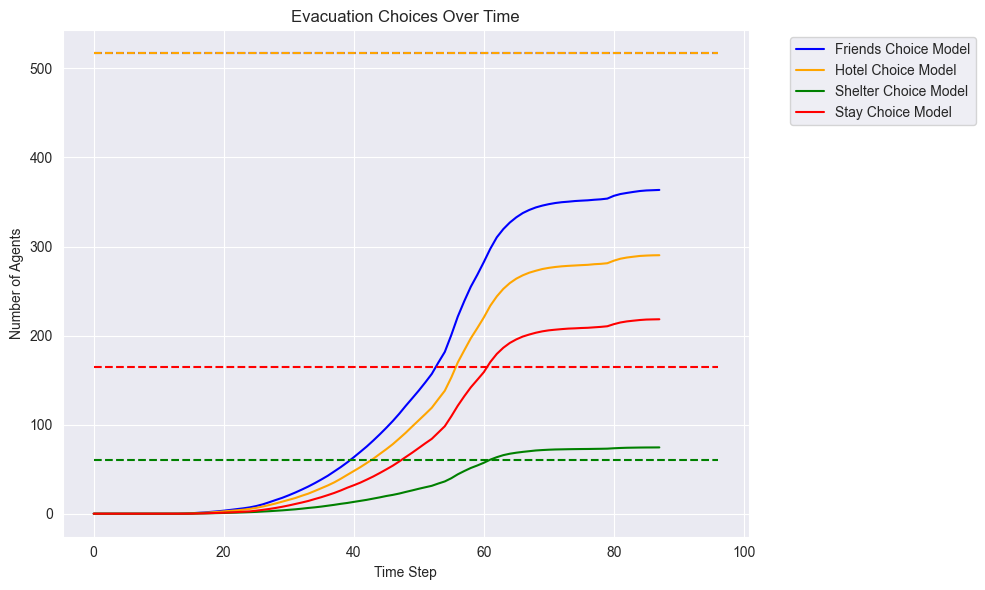

In [5]:
df_choice = df[["RunId", "iteration", "Step", "hotel_choice", "friends_choice", "shelter_choice", "stay_choice"]]
df_grouped = df_choice.groupby("Step").mean()
fig, ax = plt.subplots(figsize=(10, 6))
choice_columns = ['friends_choice',"hotel_choice", 'shelter_choice', 'stay_choice']
for choice, color in zip(choice_columns, ['blue', 'orange', 'green', 'red']):
    sns.lineplot(x=df_grouped.index, y=df_grouped[choice], label=choice.replace('_', ' ').title(), color=color)
plt.hlines(y=[516.883881,516.883881,  60.555434, 164.364749], xmin=0, xmax=96,
           colors=['blue', 'orange', 'green', 'red'], linestyles=['--', '--', '--', '--'])
plt.xlabel('Time Step')
plt.ylabel('Number of Agents')
plt.title('Evacuation Choices Over Time')

# Create custom legend elements
custom_lines = [Line2D([0], [0], color=c, linestyle='-') for c in ['blue', 'orange', 'green', 'red']]
# custom_lines.extend([Line2D([0], [0], color=c, linestyle='--') for c in ['blue', 'orange', 'green', 'red']])
labels = [f'{choice.replace("_", " ").title()} Model' for choice in choice_columns]
labels.extend([f'{choice.replace("_", " ").title()} Survey' for choice in choice_columns])

plt.legend(custom_lines, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

plt.show()

## Evacuation choice - Line with 95% confidence interval

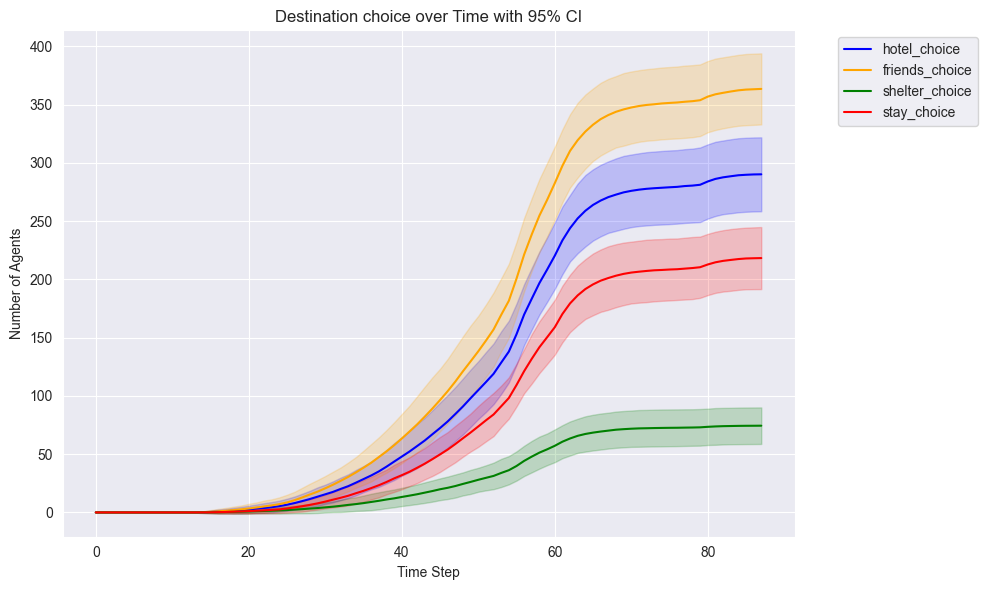

In [29]:
plt.figure(figsize=(10, 6))
colors = ['blue', 'orange', 'green', 'red']
phase_names = ["hotel_choice", "friends_choice", "shelter_choice", "stay_choice"]

for i, phase in enumerate(["hotel_choice", "friends_choice", "shelter_choice", "stay_choice"]):
    df_phase = df[["Step", phase]].groupby("Step").agg(['mean', 'std']).reset_index()
    df_phase.columns = ['Step', 'mean', 'std']

    # Plot mean line
    sns.lineplot(data=df_phase, x='Step', y='mean',
                 label=phase_names[i],
                 color=colors[i])

    # Add confidence intervals
    plt.fill_between(df_phase['Step'],
                     df_phase['mean'] - 1.96 * df_phase['std'],
                     df_phase['mean'] + 1.96 * df_phase['std'],
                     alpha=0.2,
                     color=colors[i])

plt.xlabel('Time Step')
plt.ylabel('Number of Agents')
plt.title('Destination choice over Time with 95% CI')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Evacuation choice - Bar
This code generates a bar plot that compares the number of agents choosing each evacuation option at the final simulation step with reference values. The chart shows results from the model and survey or literature values side by side for each option. It also includes an additional bar segment for indecisive agents, which are those not making an active choice, stacked on the "Stay" choice.




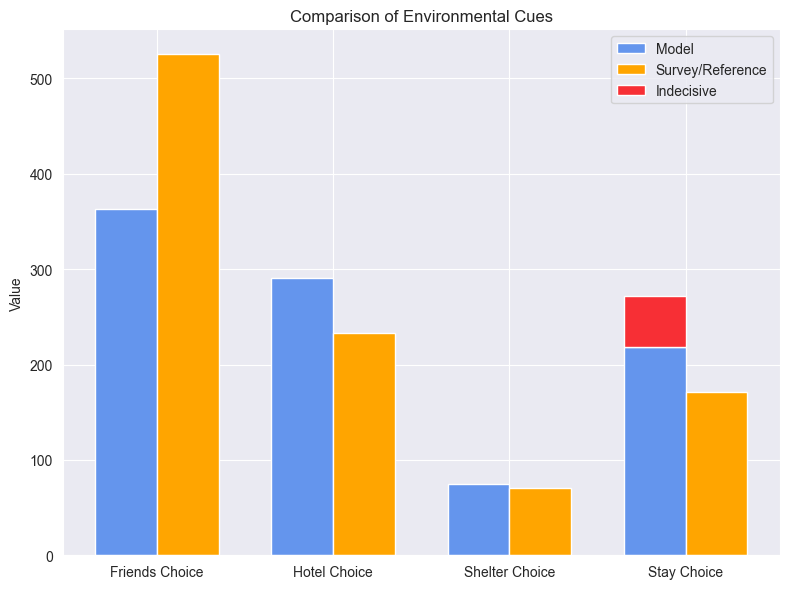

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Select the wanted columns
choice_columns = ['friends_choice',"hotel_choice", 'shelter_choice', 'stay_choice']
# Select values of last step
target_step = df['Step'].max()
env_values = df[df['Step'] == target_step][choice_columns].mean().values
# Determine number of indecesive agents on last step
indecesive_agents = 1000 - df_grouped[["hotel_choice","friends_choice","shelter_choice","stay_choice"]].loc[87].sum()

# Vertical reference values from survey
ref_values = [525.073746, 233.038348, 70.796460, 171.091445]
# Create labels
labels = [col.replace('_', ' ').title() for col in choice_columns]
x = np.arange(len(choice_columns))

fig, ax = plt.subplots(figsize=(8, 6))

# Create base bars
bar_width = 0.35
bars = ax.bar(x - bar_width / 2, env_values, bar_width, label='Model', color='cornflowerblue')
bars2 = ax.bar(x + bar_width / 2, ref_values, bar_width, label='Survey/Reference', color='orange')

# Add indecisive agents to stay bar
ax.bar(3 - bar_width / 2, indecesive_agents, bar_width, bottom=env_values[3],
       label='Indecisive', color='#F72F35')

ax.set_ylabel('Value')
ax.set_title('Comparison of Environmental Cues')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()


## Evacuation choice - Numbers
Cell below gives the proportions of the made choices. Indecisive agents are added to the stay option.

In [24]:
env_values[3]/1000
env_values[3] = env_values[3] +indecesive_agents
env_values = env_values / 1000
print("Proportions:", env_values)

Proportions: [0.36352731 0.29022375 0.07444137 0.27180757]


Cell below gives the proportions of the made choices. Without indecisive agents

In [26]:
print("Proportions:",
      env_values[0]/env_values[:-1].sum(),
      env_values[1]/env_values[:-1].sum(),
      env_values[2]/env_values[:-1].sum()
)

Proportions: 0.4992187435483116 0.39855365189648667 0.10222760455520168


## Evacuation timings - Histogram
This code creates a histogram that shows when agents in the simulation make evacuation decisions over time. The x-axis represents the simulation steps, and the histogram displays how many agents decide to evacuate at each step. Two vertical dashed lines indicate important events: the storm watch and storm warning, occurring at specific steps. Each event is labeled on the plot. The chart uses a secondary x-axis at the top, which shows the actual dates of Hurricane Irma.

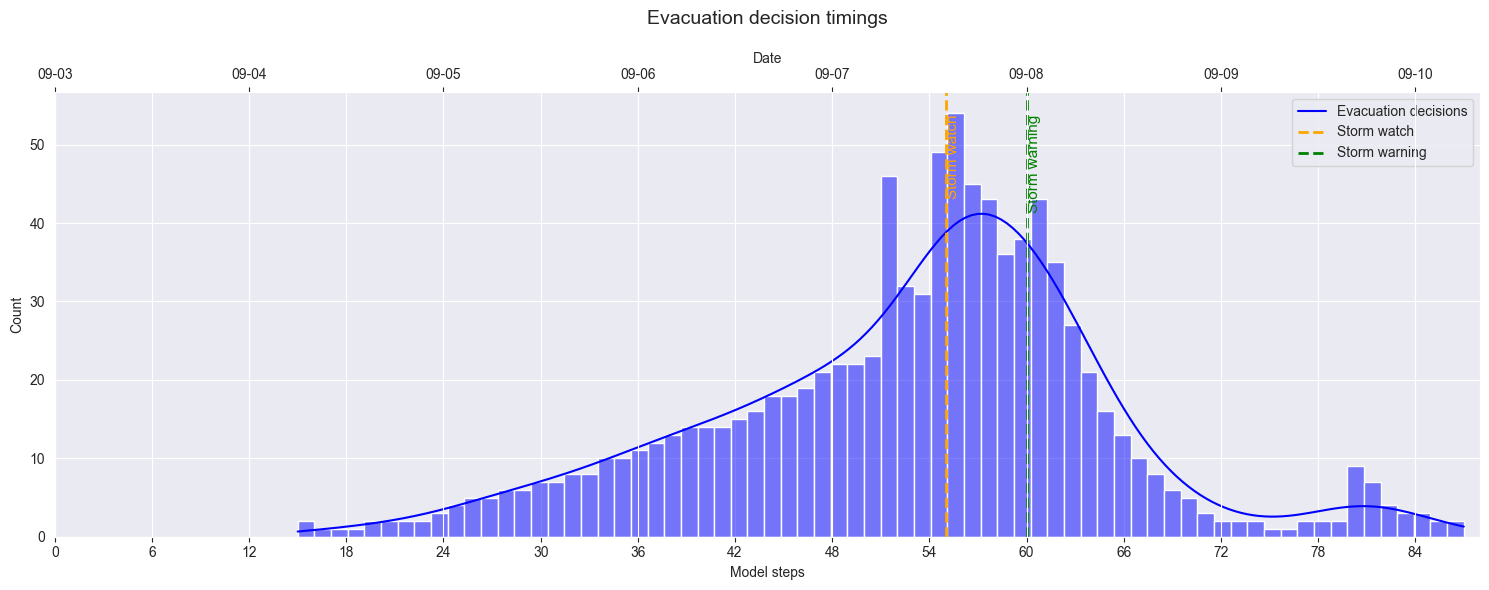

In [21]:
from datetime import datetime, timedelta

df_evac_grouped = df[["RunId", "iteration", "Step", "evac_agents"]].groupby(by=["Step"]).mean()
evac_list = []
for index, value in enumerate(df_evac_grouped["evac_agents"]):
    for _ in range(round(value)):
        evac_list.append(index)

# Plot
fig, ax1 = plt.subplots(figsize=(15, 6))

# Create a twin axis
ax2 = ax1.twiny()

# Plot on primary axis
sns.histplot(data=evac_list, bins=70, kde=True, color="blue", ax=ax1)

# Add vertical lines
line1 = ax1.axvline(55, color='orange', linestyle='--', linewidth=2, label='Storm watch')
ax1.text(55, ax1.get_ylim()[1] * 0.95, "Storm watch", color='orange', rotation=90, verticalalignment='top',
         fontsize=11)
# Vertical lines
line2 = ax1.axvline(60, color='green', linestyle='--', linewidth=2, label='Storm warning')
ax1.text(60, ax1.get_ylim()[1] * 0.95, "Storm warning", color='green', rotation=90, verticalalignment='top',
         fontsize=11)

ax1.legend(['Evacuation decisions', 'Storm watch', 'Storm warning'])
# Set up second x-axis with dates
start_date = datetime(2017, 9, 3)

def step_to_date(step):
    return start_date + timedelta(hours=2 * step)

# Configure primary x-axis
ax1.set_xlabel("Model steps")
ax1.set_xlim(0, 88)

# Configure secondary x-axis
ax2.set_xlim(0, 88)
dates = [step_to_date(step) for step in range(0, 88, 12)]  # Increased frequency
ax2.set_xticks(range(0, 88, 12))
ax2.set_xticklabels([d.strftime('%m-%d') for d in dates], rotation=0)
ax2.set_xlabel("Date")

# Set more frequent ticks for primary axis
ax1.set_xticks(range(0, 88, 6))

plt.title("Evacuation decision timings", fontsize=14, pad=20)
plt.tight_layout()
plt.show() 


## Evacuation timings validation - Histogram
This code compares the timing of evacuation decisions from the simulation model with real survey data. It builds two sets of timestamps: one based on the simulated decisions, where each agent’s decision time is calculated by adding hours to a starting date according to the simulation step, and another taken directly from actual evacuation data that is converted into datetime format. Both datasets are then filtered to lie within the chosen time window. The code plots the distributions for these two datasets together as overlapping histograms, allowing for a visual comparison of evacuation timing patterns between the model and observed behavior.

<span style="color:red"> Results are probably not corresponding to what is seen in report, since it is run with 1000 agents and not 640 ageentts </span>.


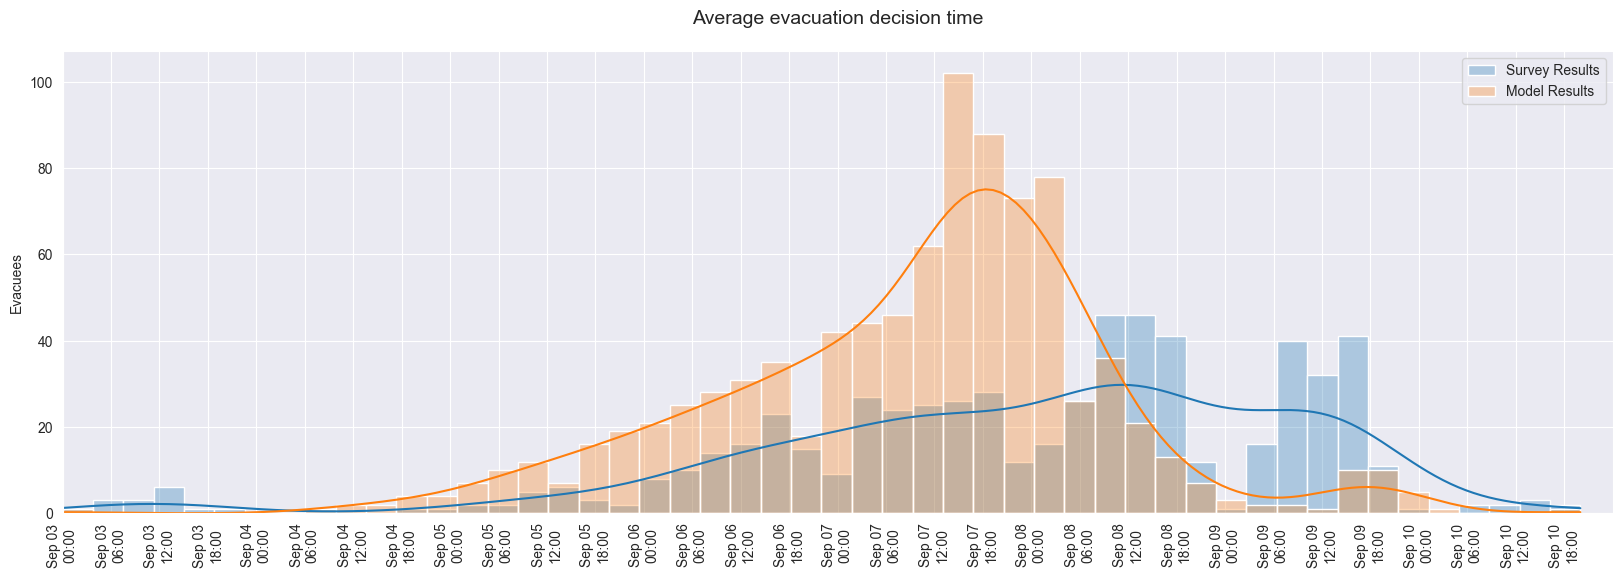

In [28]:
data_model = df_evac_grouped.reset_index()
# Use same start_time and step_hours as elsewhere
start_time = pd.Timestamp("2017-09-03 00:00:00")
end = pd.Timestamp("2017-09-10 23:59:00")
step_hours = 2
evac_agents = data_model["evac_agents"]

# Build a DataFrame with datetime for each step
df_model = pd.DataFrame({
    "evac_agents": evac_agents,
})
df_model["datetime"] = start_time + pd.to_timedelta(df_model.index * step_hours, unit="h")

# Now expand for histogram (builds the list as in your old hist_values)
hist_values = [start_time,pd.Timestamp('2017-09-10 20:00:00')]
for idx, count in enumerate(evac_agents):
    hist_values.extend([df_model.loc[idx, "datetime"]] * int(count))

# --- Real data section unchanged, except its datetime also lands in 'datetime' column ---
df_irma = pd.read_csv(r"C:\Users\roelo\Downloads\times_irma.csv").reset_index()
df_clean = df_irma.dropna()
df_clean['last_9_chars'] = df_clean['Column81;Column82'].str[-10:]

def convert_custom_datetime_column(series, year=2017, month=9):
    def parse_date(val):
        try:
            # Replace semicolon and parse
            val = val.replace(";", " ")
            partial_dt = datetime.strptime(val, "%d %I:%M %p")
            return datetime(year=year, month=month, day=partial_dt.day, hour=partial_dt.hour, minute=partial_dt.minute)
        except:
            return None
    return series.apply(parse_date)

df_clean["datetime"] = convert_custom_datetime_column(df_clean["last_9_chars"])



mask = (df_clean["datetime"] >= start_time) & (df_clean["datetime"] <= end)
df_filtered = df_clean.loc[mask]

fig, ax = plt.subplots(figsize=(20, 6))

sns.histplot(x=list(df_filtered["datetime"]), ax=ax, bins=50, kde=True, label='Survey Results',alpha=.3)
sns.histplot(x=hist_values, ax=ax, bins=50, kde=True, label='Model Results',alpha=.3)
ax.legend()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d\n%H:%M'))
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("Evacuees")
ax.set_xlim(start_time, end)
ax.set_title("Average evacuation decision time", fontsize=14, pad=20)
plt.show()



## Phase change - Stacked area
This function visualizes how the distribution of agents across different decision-making phases changes over the course of a simulation. For each simulation step, it calculates how many agents are in each phase and normalizes these counts by the total number of simulated agents. The phases represent different stages of the evacuation decision process, such as identifying risk, assessing risk, and considering protective actions. The visualization uses a stackplot to show what proportion of agents are in each phase at each step. It also marks key storm events with vertical lines labeled as storm watch and storm warning. The x-axis displays both model steps and corresponding calendar dates, making it easier to interpret the timeline of decision processes.

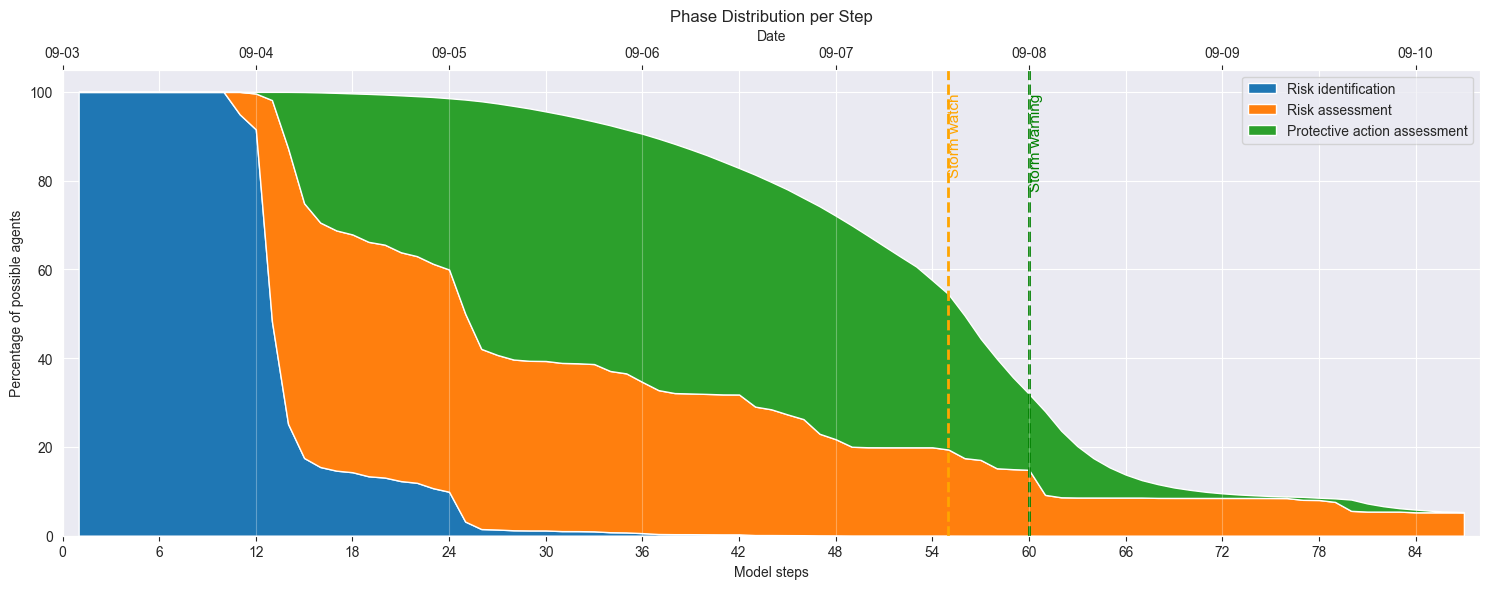

In [14]:
from datetime import datetime, timedelta

def phase_plot(data, iterations=1500):
    data_grouped = data.groupby(by=["Step", "phase"]).count()

    # Reshape the grouped data
    df_unstacked = data_grouped.unstack(level=1).fillna(0)
    df_unstacked = df_unstacked.sort_index(axis=1)

    # Only work with AgentID counts
    agent_counts = df_unstacked['AgentID']
    agent_percent = agent_counts.divide(iterations)  # scale to total possible

    steps = agent_percent.index
    phase_values = [agent_percent[phase] for phase in agent_percent.columns]

    phase_labels = {0: 'Risk identification',
                    1: 'Risk assessment',
                    2: 'Protective action assessment'}

    fig, ax1 = plt.subplots(figsize=(15, 6))
    # Stackplot of phases
    ax1.stackplot(steps, phase_values, labels=[phase_labels.get(p, f'Phase {p}') for p in agent_percent.columns])
    ax1.legend(loc='upper left')
    ax1.set_xlabel('Model steps')
    ax1.set_ylabel('Percentage of possible agents')
    ax1.set_title('Phase Distribution per Step')

    # Storm event lines
    ax1.axvline(55, color='orange', linestyle='--', linewidth=2)
    ax1.text(55, ax1.get_ylim()[1] * 0.95, "Storm watch", color='orange',
             rotation=90, verticalalignment='top', fontsize=11)
    ax1.axvline(60, color='green', linestyle='--', linewidth=2)
    ax1.text(60, ax1.get_ylim()[1] * 0.95, "Storm warning", color='green',
             rotation=90, verticalalignment='top', fontsize=11)

    # Set up second x-axis with dates
    start_date = datetime(2017, 9, 3)
    def step_to_date(step):
        return start_date + timedelta(hours=2 * step)
    plt.legend(loc='upper right')
    ax2 = ax1.twiny()
    ax1.set_xlim(0, 88)
    ax2.set_xlim(0, 88)
    date_steps = range(0, 88, 12)
    dates = [step_to_date(step) for step in date_steps]
    ax2.set_xticks(date_steps)
    ax2.set_xticklabels([d.strftime('%m-%d') for d in dates], rotation=0)
    ax2.set_xlabel("Date")

    # Set more frequent ticks for primary axis
    ax1.set_xticks(range(0, 88, 6))

    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.show()

phase_plot(df)


## Phase change - Line plot with 95% confidence interval
This code generates a line plot that shows how the number of agents in each decision-making phase evolves over time during the simulation. For each phase, it calculates the mean and standard deviation of the number of agents at every simulation step. The mean value is shown as a colored line, and the area surrounding the line represents the 95 percent confidence interval by shading between the mean minus and plus 1.96 times the standard deviation. This provides a clear visualization of both the trends and variability in how agents progress through the risk identification, risk assessment, and protective action assessment phases.

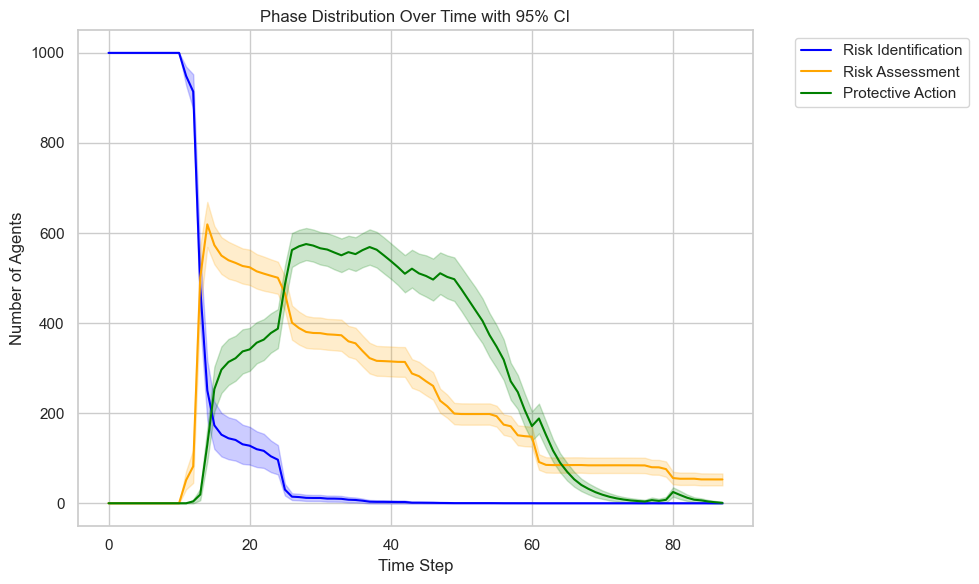

In [62]:
plt.figure(figsize=(10, 6))
colors = ['blue', 'orange', 'green']
phase_names = ['Risk Identification', 'Risk Assessment', 'Protective Action']

for i, phase in enumerate(['phase_0', 'phase_1', 'phase_2']):
    df_phase = df[["Step", phase]].groupby("Step").agg(['mean', 'std']).reset_index()
    df_phase.columns = ['Step', 'mean', 'std']

    # Plot mean line
    sns.lineplot(data=df_phase, x='Step', y='mean',
                 label=phase_names[i],
                 color=colors[i])

    # Add confidence intervals
    plt.fill_between(df_phase['Step'],
                     df_phase['mean'] - 1.96 * df_phase['std'],
                     df_phase['mean'] + 1.96 * df_phase['std'],
                     alpha=0.2,
                     color=colors[i])

# Add vertical lines for events    


plt.xlabel('Time Step')
plt.ylabel('Number of Agents')
plt.title('Phase Distribution Over Time with 95% CI')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Internal variables - Line
The code gives a plot that visualizes how environmental and social cues evolve throughout the model. It shows the average values of the internal values like risk perception, wind cues, rain cues, media influence, and propensity to act at each step. The plot also marks periods of storm surge watch and warning with colored lines and annotations. The graph shows time steps and matching calendar dates shown on dual x-axes.


In [36]:
import matplotlib as mpl
from datetime import timedelta, datetime

def plot_environmental_and_social_cues(df):
    df = df.copy()

    # Changes the font ofgraph
    mpl.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman', 'Computer Modern Roman'],
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'legend.fontsize': 10,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })

    sns.set(style="whitegrid", palette="muted")
    fig, ax1 = plt.subplots(figsize=(15, 6))

    # Plot main cues
    sns.lineplot(x=df.index, y=df["risk_perception"], ax=ax1, label='Risk perception', color='#D81B60', linewidth=2)
    sns.lineplot(x=df.index, y=df["wind_cue"], ax=ax1, label='Wind Cue', color='#1E88E5', linewidth=2)
    sns.lineplot(x=df.index, y=df["rain_cue"], ax=ax1, label='Rain Cue', color='#004D40', linewidth=2)
    sns.lineplot(x=df.index, y=df["media_cue"], ax=ax1, label='Media Cue', color='#FFC107', linewidth=2)
    sns.lineplot(x=df.index, y=df["immediacy"], ax=ax1, label='Propensity', color='#7B1FA2', linewidth=2)
    sns.lineplot(x=df.index, y=df["watch"], color='#FF7043', linewidth=1.5, label='Storm surge Watch', linestyle='-')
    sns.lineplot(x=df.index, y=df["warning"], color='#43A047', linewidth=1.5, label='Storm surge Warning', linestyle='-')

    # Event lines
    ax1.axvline(55, color='#FF7043', linestyle='--', linewidth=2)
    ax1.text(55, ax1.get_ylim()[1] * 0.95, "Storm watch", color='#FF7043',
             rotation=90, verticalalignment='top', fontsize=11)
    ax1.axvline(60, color='#43A047', linestyle='--', linewidth=2)
    ax1.text(60, ax1.get_ylim()[1] * 0.95, "Storm warning", color='#43A047',
             rotation=90, verticalalignment='top', fontsize=11)

    # Date-based secondary x-axis
    def step_to_date(step):
        start_date = datetime(2017, 9, 3)
        return start_date + timedelta(hours=2 * step)

    date_steps = range(0, 88, 6)
    date_steps_1 = range(0, 88, 12)
    dates = [step_to_date(step) for step in date_steps_1]

    ax1.set_xlim(0, 88)
    ax1.set_xticks(date_steps)  # Add extra x-ticks (every 12 steps)

    ax2 = ax1.twiny()
    ax2.set_xlim(0, 88)
    ax2.set_xticks(date_steps_1)
    ax2.set_xticklabels([d.strftime('%m-%d') for d in dates], rotation=0)
    ax2.set_xlabel("Date")

    ax1.set_title("Environmental and Social Cues")
    ax1.set_xlabel("Time Steps")
    ax1.set_ylabel("Cue Intensity")
    ax1.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

df["watch"] = [1  if x==0.5 else 0 for x in df["storm_surge_state"]]
df["warning"] = [1  if x==1 else 0 for x in df["storm_surge_state"]]
df_evac_grouped = df[["risk_perception","wind_cue","rain_cue","media_cue","immediacy","watch","warning","Step"]].groupby(by=["Step"]).mean()

plot_environmental_and_social_cues(df_evac_grouped)

KeyError: 'storm_surge_state'

## Internal variables - Line with 95% confidence interval
Same plot as above but seperated into two subplots with the confidence interval added.

KeyError: "None of [Index(['Step', 'wind_cue'], dtype='object')] are in the [columns]"

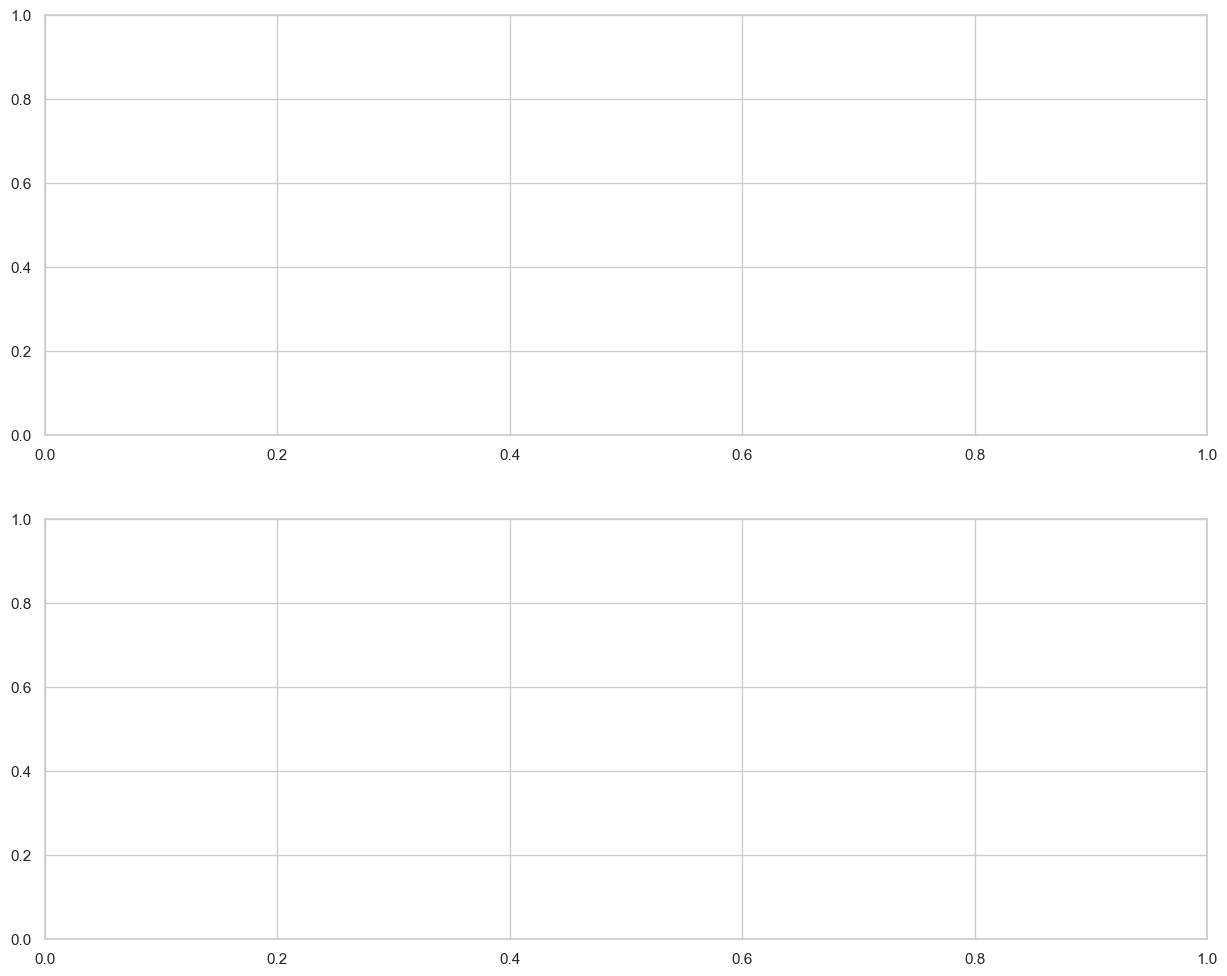

In [35]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

colors = ['#1E88E5', '#004D40', '#FFC107', '#D81B60', '#7B1FA2', '#FF7043', '#43A047']

# First subplot - environmental cues
env_vars = ["wind_cue", "rain_cue", "media_cue"]
env_names = ["Wind Cue", "Rain Cue", "Media Cue"]

for i, var in enumerate(env_vars):
    df_phase = df[["Step", var]].groupby("Step").agg(['mean', 'std']).reset_index()
    df_phase.columns = ['Step', 'mean', 'std']

    sns.lineplot(data=df_phase, x='Step', y='mean',
                 label=env_names[i],
                 color=colors[i],
                 ax=ax1)

    ax1.fill_between(df_phase['Step'],
                     df_phase['mean'] - 1.96 * df_phase['std'],
                     df_phase['mean'] + 1.96 * df_phase['std'],
                     alpha=0.2,
                     color=colors[i])

ax1.set_xlabel('Time Step')
ax1.set_ylabel('Cue Intensity')
ax1.set_title('Environmental and Social Cues')
ax1.grid(True)
ax1.legend(loc='upper left')

# Second subplot - risk perception and indicators
other_vars = ["risk_perception", "immediacy", "watch", "warning"]
other_names = ["Risk Perception", "Propensity", "Storm surge Watch", "Storm surge Warning"]

for i, var in enumerate(other_vars):
    df_phase = df[["Step", var]].groupby("Step").agg(['mean', 'std']).reset_index()
    df_phase.columns = ['Step', 'mean', 'std']

    sns.lineplot(data=df_phase, x='Step', y='mean',
                 label=other_names[i],
                 color=colors[i + 3],
                 ax=ax2)

    ax2.fill_between(df_phase['Step'],
                     df_phase['mean'] - 1.96 * df_phase['std'],
                     df_phase['mean'] + 1.96 * df_phase['std'],
                     alpha=0.2,
                     color=colors[i + 3])
ax1.set_xlim(0,87)
ax2.set_xlim(0,87)
ax1.set_ylim(-0.50,1.5)
ax2.set_ylim(-0.50,1.5)
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Value')
ax2.set_title('Risk Perception and Storm Indicators')
ax2.grid(True)
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()